In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Container setup from image (multiplier, inhabitants)
containers = [
    {"mult": 10, "inhab": 1},
    {"mult": 80, "inhab": 6},
    {"mult": 37, "inhab": 3},
    {"mult": 17, "inhab": 1},
    {"mult": 31, "inhab": 2},
    {"mult": 50, "inhab": 4},
    {"mult": 89, "inhab": 8},
    {"mult": 73, "inhab": 4},
    {"mult": 20, "inhab": 2},
    {"mult": 90, "inhab": 10}
]

BASE_TREASURE = 10000
N_GEN = 100
ALPHA = 0.05  # Exponential moving average factor
TEMPERATURE = 50000  # Softmax temperature (10,000 - 100,000)
# Low temp = game theory optimal
# High temp = random exploration

n = len(containers)
avg_ev = np.zeros(n)
popularity = np.ones(n)  # Start with equal assumption

# monte carlo section

In [61]:
from copy import deepcopy
from tqdm import tqdm
# Container setup from image (multiplier, inhabitants)

starting_containers = [
    {"mult": 10, "inhab": 1,  'picks' : 0, 'density' : 0},
    {"mult": 80, "inhab": 6,  'picks' : 0, 'density' : 0},
    {"mult": 37, "inhab": 3,  'picks' : 0, 'density' : 0},
    {"mult": 17, "inhab": 1,  'picks' : 0, 'density' : 0},
    {"mult": 31, "inhab": 2,  'picks' : 0, 'density' : 0},
    {"mult": 50, "inhab": 4,  'picks' : 0, 'density' : 0},
    {"mult": 89, "inhab": 8,  'picks' : 0, 'density' : 0},
    {"mult": 73, "inhab": 4,  'picks' : 0, 'density' : 0},
    {"mult": 20, "inhab": 2,  'picks' : 0, 'density' : 0},
    {"mult": 90, "inhab": 10, 'picks' : 0, 'density' : 0}
]

def calculate_nash(containers, n_players, total_picks, return_sortred=False):

    containers = deepcopy(containers)
    BASE_TREASURE = 10000

    for i in tqdm(range(n_players)):
        # calculate expected value for each container
        if total_picks == 0:
            best = 0
            index = 0
            for i, container in enumerate(containers):
                ev = BASE_TREASURE * container["mult"] / container["inhab"]
                if ev > best:
                    best = ev
                    index = i
            
            #print("Going to container ", index, "with ev", best)
            # add player to best container

        else:
            best = 0
            index = 0
            for i, container in enumerate(containers):
                ev = BASE_TREASURE * container["mult"] / (container["inhab"] + (container["picks"]/total_picks*100))
                # print(i, ev)
                if ev > best:
                    best = ev
                    index = i
            #print("Going to container ", index, "with ev", best)

            #print("=====================================")

            # add player to best container
        containers[index]["picks"] += 1
        total_picks += 1

    updated_list = []
    # Print containers sorted by picks and print stats
    for container in containers:
        # Calculate expected value for each container
        ev = BASE_TREASURE * container["mult"] / (container["inhab"] + (container["picks"]/total_picks*100))
        
        container['density'] = float(f'{container["picks"]/total_picks*100:.5f}')
        container['ev'] = ev

        thingy = (container['picks']/total_picks*100, container['inhab'], container['mult'], ev)
        updated_list.append(thingy)

    updated_list = sorted(updated_list, key=lambda x: x[0], reverse=True)
    
    if return_sortred:
        containers = sorted(containers, key=lambda x: x['density'], reverse=True)

    return containers, total_picks

def sample_container(cum_sum, plot=False):
    # pick container with value higher than val

    picked = 0
    val = np.random.uniform(0, 100)
    for index, i in enumerate(cum_sum):
        if val < i:
            picked = index
            break

    if plot:
        plt.scatter(range(0, len(cum_sum)), cum_sum, label="Cumulative sum of densities")
        plt.axhline(y=val, color='r', linestyle='--', label="Random value")
        plt.scatter(picked, cum_sum[picked], color='r', label="Picked container")

    return picked

100%|██████████| 10000/10000 [00:00<00:00, 416233.72it/s]


2

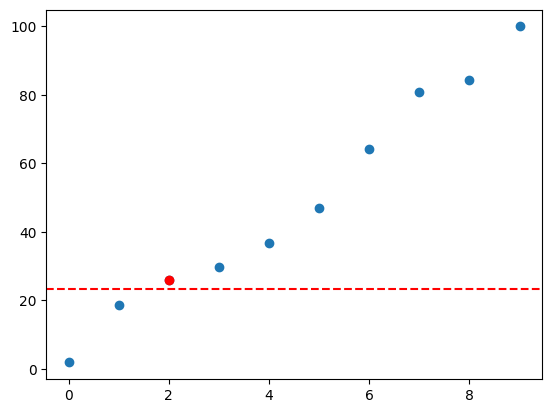

In [62]:
containers, total_picks = calculate_nash(starting_containers, 10000, 0)

densities = list(map(lambda x: x['density'], containers))
cum_sum = np.cumsum(densities)

sample_container(cum_sum, True)

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def plot_ev(containers, iter):

    # Calculate expected values
    base_treasure = 10000
    for container in containers:
        container['ev'] = base_treasure * container['mult'] / (container['inhab'] + container['density'])

    # Sort containers by expected value (highest to lowest)
    sorted_containers = sorted(containers, key=lambda x: x['ev'], reverse=True)

    # Create a 1x10 grid for the heatmap (one long row)
    fig, ax = plt.subplots(figsize=(20, 4))

    # Set background color
    ax.set_facecolor('#f0f0f0')

    # Create color scale based on expected values
    min_ev = min(c['ev'] for c in containers)
    max_ev = max(c['ev'] for c in containers)
    norm = plt.Normalize(min_ev, max_ev)
    cmap = plt.cm.viridis

    # Draw the grid cells
    for i in range(10):
        container = sorted_containers[i]
        
        # Cell position (all in one row)
        x = i * 2
        y = 0
        
        # Create rectangle with color based on expected value
        color = cmap(norm(container['ev']))
        rect = patches.Rectangle((x, y), 1.9, 2.9, linewidth=1, edgecolor='black', facecolor=color, alpha=0.7)
        ax.add_patch(rect)
        
        # Add the expected value text in the middle
        ax.text(x + 0.95, y + 1.5, f"EV: {container['ev']:.0f}", 
                ha='center', va='center', fontsize=11, fontweight='bold', color='black')
        
        # Add container details below
        ax.text(x + 0.95, y + 0.7, f"mult: {container['mult']}", 
                ha='center', va='center', fontsize=9, color='black')
        ax.text(x + 0.95, y + 0.5, f"inhab: {container['inhab']}", 
                ha='center', va='center', fontsize=9, color='black')
        ax.text(x + 0.95, y + 0.2, f"density: {container['density']:.2f}", 
                ha='center', va='center', fontsize=9, color='black')

    # Set the limits of the plot
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 3)

    # Remove axes
    ax.set_axis_off()

    # Add title
    plt.title(f'Container Expected Value Heatmap Iteration {iter} ', fontsize=16, pad=20)

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Expected Value (SeaShells)')

    plt.tight_layout()
    plt.show()

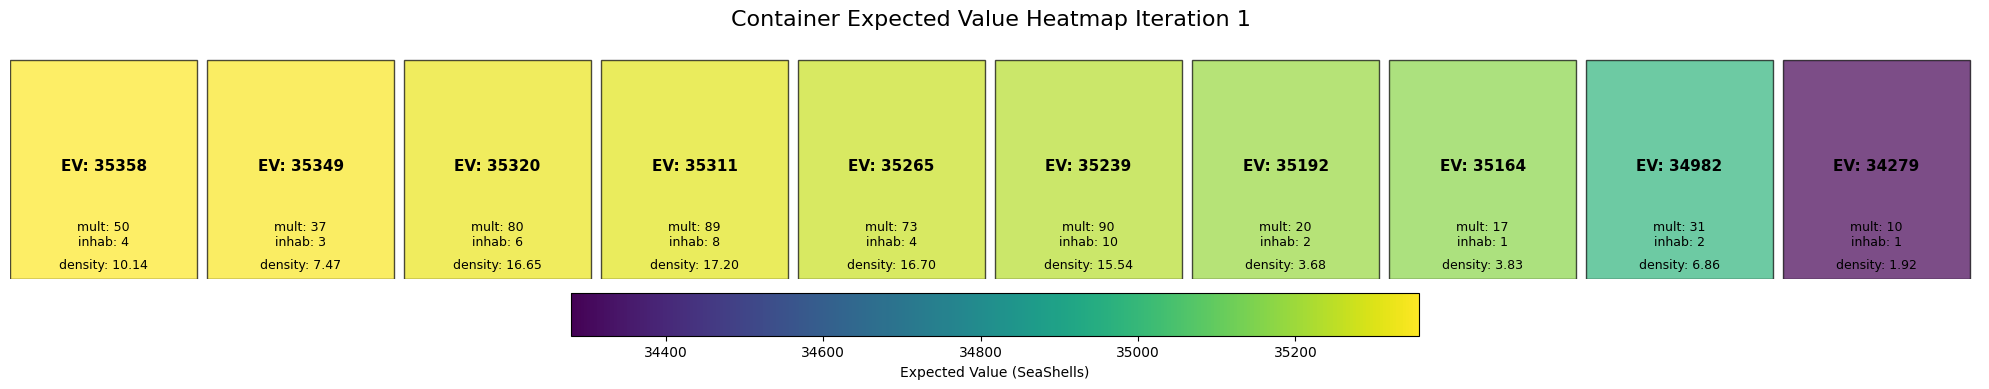

In [76]:
plot_ev(containers, 1)

# other

In [4]:
ev_history = []
prob_history = []

for gen in range(50):
    # Step 1: Compute raw EV per container
    raw_ev = np.array([
        BASE_TREASURE * c["mult"] / (c["inhab"] + popularity[i])
        for i, c in enumerate(containers)
    ])
    
    # Step 2: Softmax to simulate player choice distribution
    shifted_ev = raw_ev / (TEMPERATURE)  # Scale by temperature
    shifted_ev -= np.max(shifted_ev)  # For numerical stability
    exp_scaled = np.exp(shifted_ev)
    probs = exp_scaled / np.sum(exp_scaled)
    
    # # Step 2: linear
    # min_ev = raw_ev.min()
    # range_ev = raw_ev.max() - min_ev
    # if range_ev == 0:
    #     probs = np.ones_like(raw_ev) / len(raw_ev)  # fallback if all values are equal
    # else:
    #     scaled = (raw_ev - min_ev) / range_ev
    #     probs = scaled / scaled.sum()
    
    # Step 3: Use these probs as popularity estimates for next round
    popularity = probs * 100

    # Step 4: Compute actual EV with updated popularity
    true_ev = np.array([
        BASE_TREASURE * c["mult"] / (c["inhab"] + popularity[i])
        for i, c in enumerate(containers)
    ])

    # Track for plot
    ev_history.append(true_ev.copy())
    prob_history.append(popularity.copy())
    
ev_history = np.array(ev_history)
prob_history = np.array(prob_history)

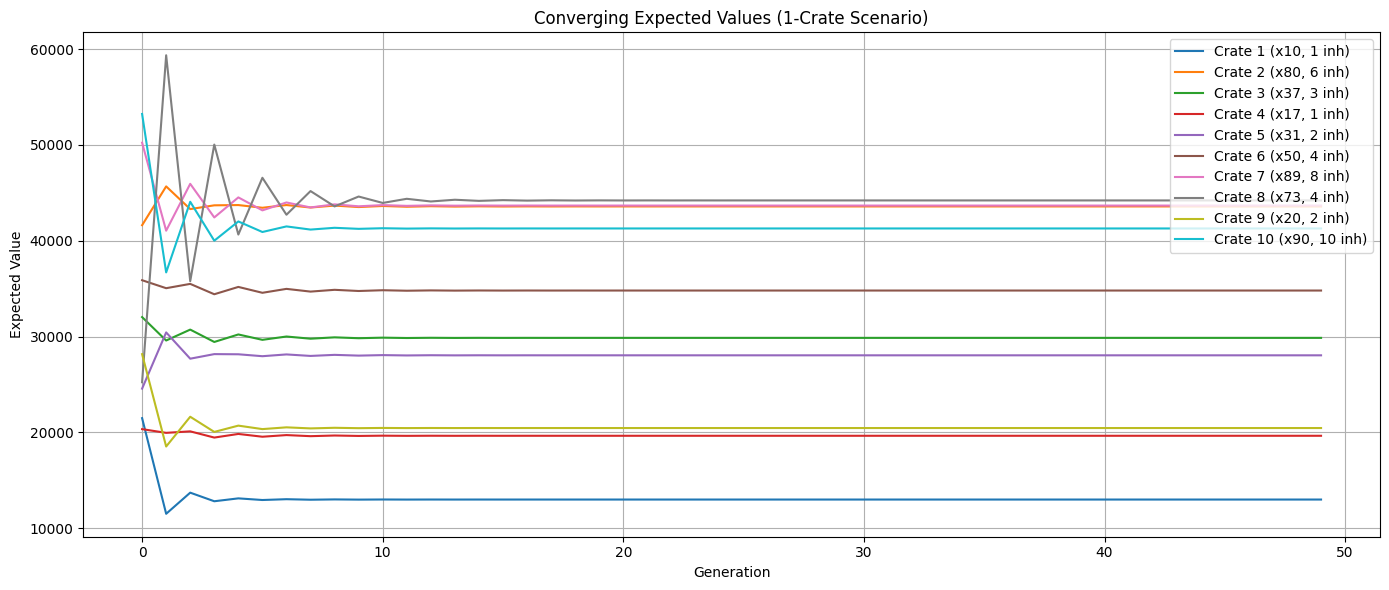

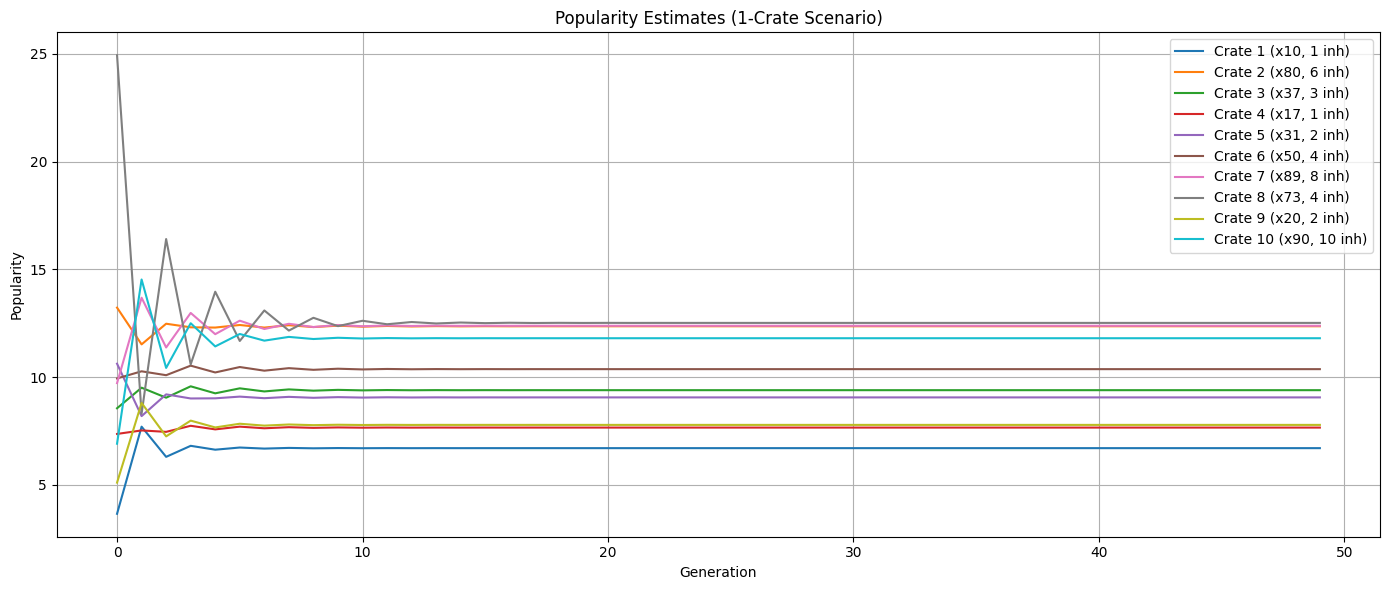

In [5]:
# Plot avg ev
plt.figure(figsize=(14, 6))

for i in range(n):
    plt.plot(ev_history[:, i], label=f"Crate {i+1} (x{containers[i]['mult']}, {containers[i]['inhab']} inh)")

plt.title("Converging Expected Values (1-Crate Scenario)")
plt.xlabel("Generation")
plt.ylabel("Expected Value")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# plot popularity
plt.figure(figsize=(14, 6))

for i in range(n):
    plt.plot(prob_history[:, i], label=f"Crate {i+1} (x{containers[i]['mult']}, {containers[i]['inhab']} inh)")
    
plt.title("Popularity Estimates (1-Crate Scenario)")
plt.xlabel("Generation")
plt.ylabel("Popularity")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


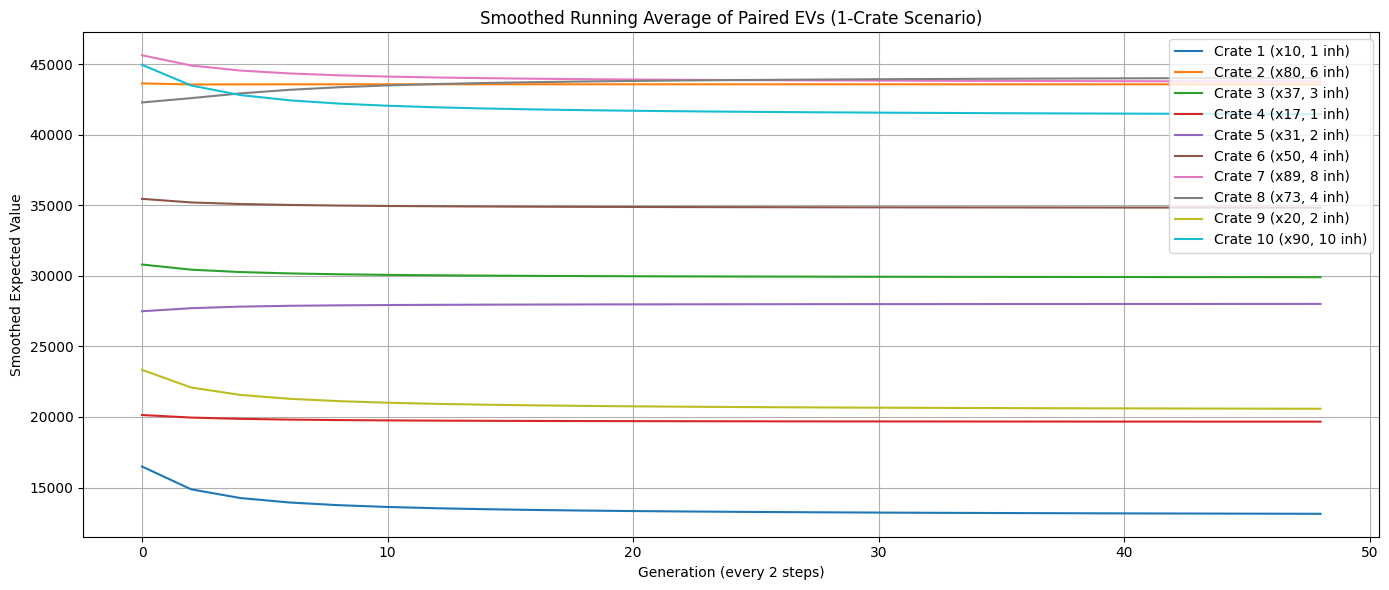

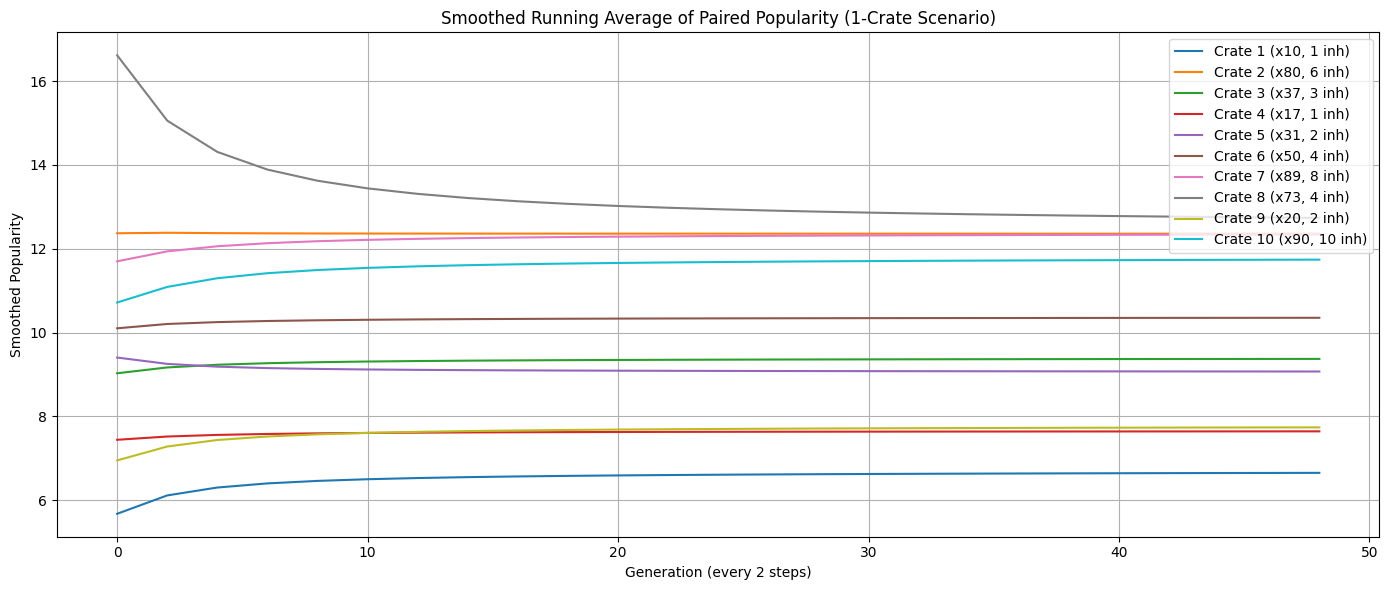

Final Expected Values After Convergence:

      Crate  Multiplier  Inhabitants  Final EV  Final Popularity
0   Crate 8          73            4  44038.19             12.74
1   Crate 7          89            8  43782.55             12.34
2   Crate 2          80            6  43582.14             12.36
3  Crate 10          90           10  41469.43             11.74
4   Crate 6          50            4  34839.78             10.35
5   Crate 3          37            3  29911.52              9.37
6   Crate 5          31            2  28015.38              9.07
7   Crate 9          20            2  20584.63              7.74
8   Crate 4          17            1  19669.40              7.64
9   Crate 1          10            1  13138.04              6.65


In [6]:
# Average every 2 consecutive generations (pair smoothing)
paired_avg_ev = (ev_history[::2] + ev_history[1::2]) / 2

# Compute running average of paired EVs
running_avg_ev = np.cumsum(paired_avg_ev, axis=0) / np.arange(1, len(paired_avg_ev) + 1)[:, None]

# Plot the running average of paired EVs
plt.figure(figsize=(14, 6))
for i in range(n):
    plt.plot(np.arange(len(running_avg_ev)) * 2, running_avg_ev[:, i],
             label=f"Crate {i+1} (x{containers[i]['mult']}, {containers[i]['inhab']} inh)")

plt.title("Smoothed Running Average of Paired EVs (1-Crate Scenario)")
plt.xlabel("Generation (every 2 steps)")
plt.ylabel("Smoothed Expected Value")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# average popularity every 2 consecutive generations (pair smoothing)
paired_avg_pop = (prob_history[::2] + prob_history[1::2]) / 2

running_avg_pop = np.cumsum(paired_avg_pop, axis=0) / np.arange(1, len(paired_avg_pop) + 1)[:, None]

# Plot the running average of paired popularity
plt.figure(figsize=(14, 6))
for i in range(n):
    plt.plot(np.arange(len(running_avg_pop)) * 2, running_avg_pop[:, i],
             label=f"Crate {i+1} (x{containers[i]['mult']}, {containers[i]['inhab']} inh)")
    
plt.title("Smoothed Running Average of Paired Popularity (1-Crate Scenario)")
plt.xlabel("Generation (every 2 steps)")
plt.ylabel("Smoothed Popularity")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Get the final EVs from the last running average row
final_running_evs = running_avg_ev[-1]
final_running_pop = running_avg_pop[-1]

# Build and sort a DataFrame to display
final_df = pd.DataFrame({
    "Crate": [f"Crate {i+1}" for i in range(n)],
    "Multiplier": [c["mult"] for c in containers],
    "Inhabitants": [c["inhab"] for c in containers],
    "Final EV": final_running_evs,
    "Final Popularity": final_running_pop
}).sort_values("Final EV", ascending=False).reset_index(drop=True)

print("Final Expected Values After Convergence:\n")
print(final_df.round(2))



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Container setup
containers = [
    {"mult": 10, "inhab": 1},
    {"mult": 80, "inhab": 6},
    {"mult": 37, "inhab": 3},
    {"mult": 17, "inhab": 1},
    {"mult": 31, "inhab": 2},
    {"mult": 50, "inhab": 4},
    {"mult": 89, "inhab": 8},
    {"mult": 73, "inhab": 4},
    {"mult": 20, "inhab": 2},
    {"mult": 90, "inhab": 10}
]

BASE_TREASURE = 10000
N_GEN = 50
HEDGE_COST = 50000  # Cost of the hedge

# Softmax temperature (10,000 - 100,000)
# Low temp = game theory optimal
# High temp = random 
TEMPERATURE_MAIN = 50000
TEMPERATURE_HEDGE = 50000 

n = len(containers)

# Initial popularity
popularity = np.ones(n)

In [12]:
# Histories
pairwise_ev_history = []
popularity_history = []

for gen in range(50):
    # Step 1: Compute raw EV per container
    raw_ev = np.array([
        BASE_TREASURE * c["mult"] / (c["inhab"] + popularity[i])
        for i, c in enumerate(containers)
    ])
    
    # Step 2: Softmax to simulate player choice distribution (main crate)
    shifted_ev_main = raw_ev / (TEMPERATURE_MAIN)  # Scale by temperature
    shifted_ev_main -= np.max(shifted_ev_main)  # For numerical stability
    exp_scaled_main = np.exp(shifted_ev_main)
    main_probs = exp_scaled_main / np.sum(exp_scaled_main)
    real_main_prob = main_probs * 100

    # Step 3: Calculate player ev for main crate 
    main_ev = np.array([
        BASE_TREASURE * c["mult"] / (c["inhab"] + real_main_prob[i])
        for i, c in enumerate(containers)
    ])
    
    # Step 4: For each main crate, calculate player choice for hedge crate (-cost of hedge)
    pairwise_ev = np.full((n, n), np.nan)
    pairwise_probs = np.zeros((n, n))
    
    for i in range(n):  # main crate
        # Hedge candidates
        hedge_indices = [j for j in range(n) if j != i]
        
        # Subtract the cost of the hedge from the expected value
        hedge_raw_ev = np.array([
            BASE_TREASURE * containers[j]["mult"] / (containers[j]["inhab"] + real_main_prob[i])
            for j in hedge_indices
        ]) - HEDGE_COST
        
        hedge_ev_shifted = hedge_raw_ev / TEMPERATURE_HEDGE
        hedge_ev_shifted -= np.max(hedge_ev_shifted)
        exp_scaled_hedge = np.exp(hedge_ev_shifted)
        hedge_probs = exp_scaled_hedge / np.sum(exp_scaled_hedge)
        expected_hedge_prob = hedge_probs * 100
        
        full_hedge_probs = np.zeros(n)
        for k, j in enumerate(hedge_indices):
            full_hedge_probs[j] = expected_hedge_prob[k]

        for j in range(n):  # hedge crate
            if i != j:
                ev = main_ev[i] + raw_ev[j] - HEDGE_COST
                pairwise_ev[i, j] = ev
                pairwise_probs[i, j] = main_probs[i] * full_hedge_probs[j]
        
    # Total crate popularity from main + hedge roles
    crate_popularity = pairwise_probs.sum(axis=0) + pairwise_probs.sum(axis=1)
    popularity = crate_popularity
        
    pairwise_ev_history.append(pairwise_ev.copy())
    popularity_history.append(crate_popularity.copy())

pairwise_ev_history = np.array(pairwise_ev_history)
popularity_history = np.array(popularity_history)        

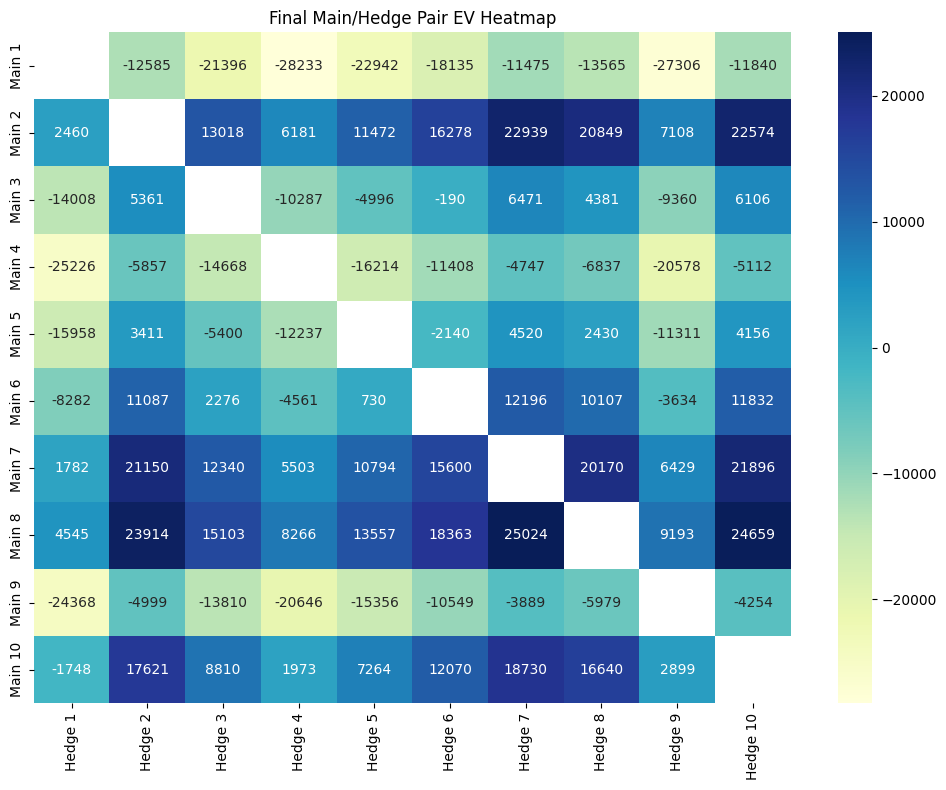

In [13]:
final_ev = pd.DataFrame(
    pairwise_ev_history[-1],
    columns=[f"Hedge {i+1}" for i in range(n)],
    index=[f"Main {i+1}" for i in range(n)]
)
plt.figure(figsize=(10, 8))
plt.title("Final Main/Hedge Pair EV Heatmap")
sns.heatmap(final_ev, annot=True, fmt=".0f", cmap="YlGnBu")
plt.tight_layout()
plt.show()

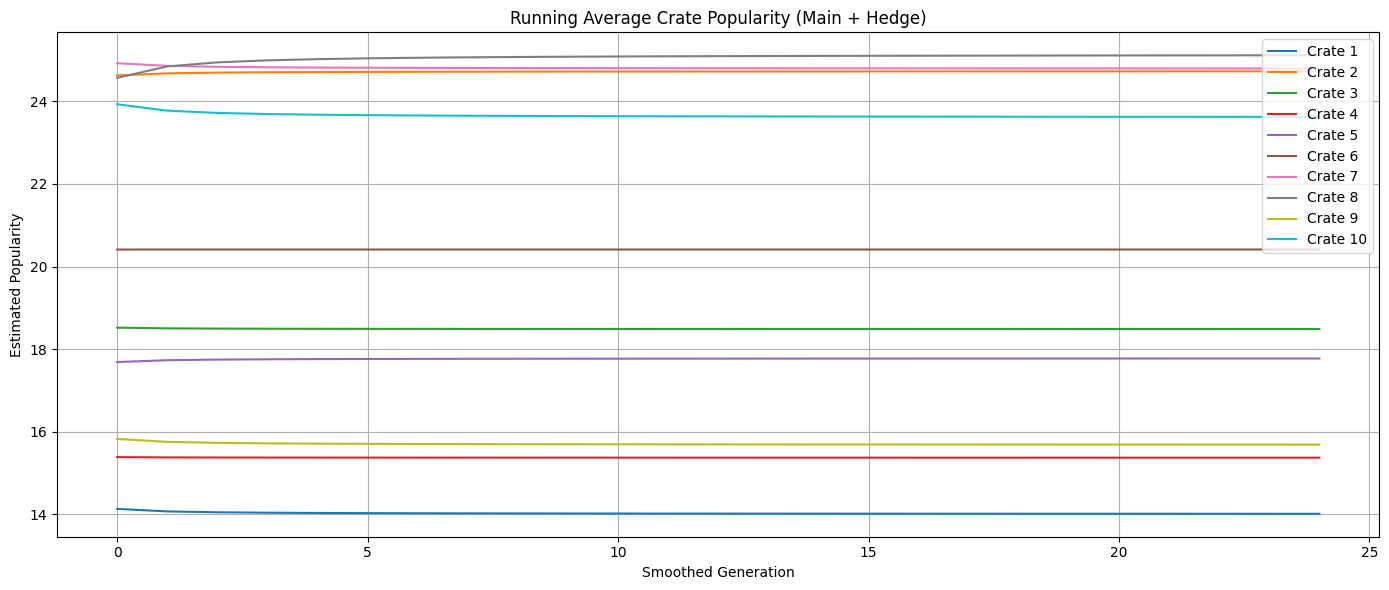

In [14]:
# Smooth every 2 generations
paired_ev_avg = (pairwise_ev_history[::2] + pairwise_ev_history[1::2]) / 2
running_mean_ev = np.cumsum(paired_ev_avg, axis=0) / np.arange(1, len(paired_ev_avg) + 1)[:, None, None]

paired_pop_avg = (popularity_history[::2] + popularity_history[1::2]) / 2
running_mean_pop = np.cumsum(paired_pop_avg, axis=0) / np.arange(1, len(paired_pop_avg) + 1)[:, None]

# Plot running mean of crate popularity
plt.figure(figsize=(14, 6))
for i in range(n):
    plt.plot(running_mean_pop[:, i], label=f"Crate {i+1}")
plt.title("Running Average Crate Popularity (Main + Hedge)")
plt.xlabel("Smoothed Generation")
plt.ylabel("Estimated Popularity")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Get final smoothed EV matrix
final_mean_matrix = running_mean_ev[-1]

# Build list of all valid (main, hedge) pairs with metadata
top_pairs = []
for i in range(n):
    for j in range(n):
        if i != j and not np.isnan(final_mean_matrix[i, j]):
            top_pairs.append({
                "Main Crate #": i + 1,
                "Main Mult": containers[i]["mult"],
                "Main Inhab": containers[i]["inhab"],
                "Hedge Crate #": j + 1,
                "Hedge Mult": containers[j]["mult"],
                "Hedge Inhab": containers[j]["inhab"],
                "Final Mean EV": final_mean_matrix[i, j]
            })

# Convert to DataFrame and sort by EV
top_df = pd.DataFrame(top_pairs).sort_values("Final Mean EV", ascending=False).head(10)

# Display results
print("Top 10 Main/Hedge Crate Pairs by Smoothed Running EV:\n")
print(top_df.round(2))


Top 10 Main/Hedge Crate Pairs by Smoothed Running EV:

    Main Crate #  Main Mult  Main Inhab  Hedge Crate #  Hedge Mult  \
69             8         73           4              7          89   
71             8         73           4             10          90   
64             8         73           4              2          80   
14             2         80           6              7          89   
17             2         80           6             10          90   
62             7         89           8             10          90   
55             7         89           8              2          80   
15             2         80           6              8          73   
60             7         89           8              8          73   
87            10         90          10              7          89   

    Hedge Inhab  Final Mean EV  
69            8       25150.29  
71           10       24821.79  
64            6       23992.22  
14            8       22983.12  
17       